In [13]:
import sys
sys.path.insert(0, "..")

In [14]:
from utils import access_raster
from glob import glob
import re
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import gaussian_kde
import seaborn as sns
import random
from scipy import optimize

In [15]:
basepath = "/home/abetatos/Escritorio/TFM_Dataset/3.Basedataset/"
aspect_path = basepath + "Aspect"
hs_path = basepath + "HS"

is_tiff = lambda x: re.search(".tiff?$", x)

def get_dataframe(path, key): 
    files = filter(is_tiff, glob(path + "/**/*", recursive=True))
    df = pd.DataFrame(files, columns=[key])
    df['file'] = df[key].apply(lambda p: Path(p).parts[-2])
    df = df.set_index("file")
    return df

def get_array(raster): 
    array = raster['array'][0]
    nodata = raster['meta']['nodata']
    array[array==nodata]=0
    return array

In [16]:
df = get_dataframe(aspect_path, "Aspect")[1:]
df['HS'] = get_dataframe(hs_path, "HS")['HS']
len(df)

15

In [17]:
def get_mapping(series):
    aspect_raster = access_raster(series['Aspect'])
    hs_raster = access_raster(series['HS'])

    aspect_array = get_array(aspect_raster)
    hs_array = get_array(hs_raster)
    
    mapping = [[a, hs] for aspect_line, hs_line in zip(aspect_array, hs_array) 
                       for a, hs in zip(aspect_line, hs_line)
                       if hs > 0]
    
    return mapping

def fit_curve(x, y, ax): 
    def test_func(x, a, b, c, d):
        return a * x**3 + b * x**2 + c * x + d

    try:
        params, params_covariance = optimize.curve_fit(test_func, x, y, p0=[1, 0, 1, 0],
                                                    method="trf", absolute_sigma=True, maxfev=5000)
    except RuntimeError: 
        print("Optimal parameters not found, fit won't be displayed")
        plt.show()
        return None
        
    # plt.figure(figsize=(6, 4))
    # plt.scatter(x, y, label='Data', s=1)

    x, y = zip(*sorted(zip(x, y)))
    x, y = np.array(x), np.array(y)
    fitted_y = test_func(x, params[0], params[1], params[2], params[3])
    # ax.plot(x, fitted_y,
    #         label='Sinus function', color="red")
    # ax.legend(loc='best')
    plt.show()    
    
    get_str = lambda x:  f"{round(x, 2)}"
    a, b, c, d = params
    print(f"Fitted function: {get_str(a)} * x^3 + {get_str(b)} * x^2 + {get_str(c)} * x + {get_str(d)}")
    
    mse = np.mean((y - fitted_y) ** 2)
    print("MSE:", mse)
    ss_res = np.sum((y - fitted_y) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_sq = 1 - (ss_res / ss_tot)
    print("R^2:", r_sq)
    
    return r_sq

def plot_map(_mapping):
    mapping = deepcopy(_mapping)
    np.random.shuffle(mapping)

    x, y = zip(*mapping[:10000])
    x, y = np.array(x), np.array(y)
    xy = np.vstack([x,y])
    kernel = gaussian_kde(xy)(xy)
    
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=kernel, s=1, label="scatter plot")
    ax.set_ylabel("HS (m)")
    ax.set_xlabel("Aspect (º)")

    fit_curve(x, y, ax)
    
    return x

def plot_slices(mapping): 
    df = pd.DataFrame(mapping)
    df[0] = df[0].apply(lambda x: round(x, 0))
    new_mapping = df.groupby(0).apply(np.mean, axis=0).values
    plot_map(new_mapping)
    return new_mapping

____________________________________________________________________________________________________ 
 HS_Saflischpass_20220512_1m_epsg2056


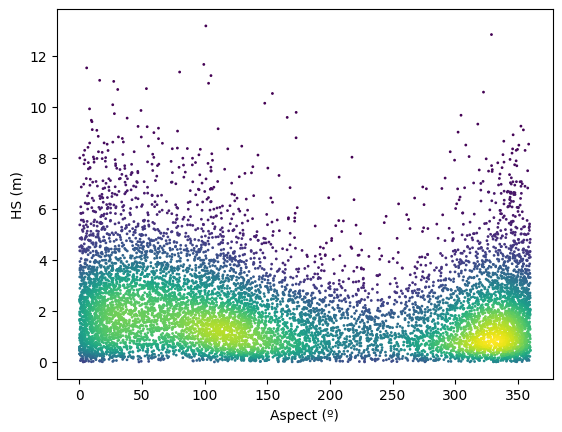

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.0 * x + 2.56
MSE: 2.6555445
R^2: 0.050616562366485596


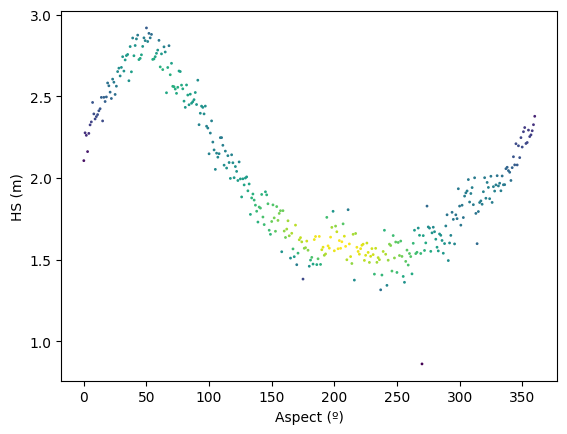

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.0 * x + 2.6
MSE: 0.02463956941020696
R^2: 0.8696924080827375
____________________________________________________________________________________________________ 
 HS_Laucherenalp_20220511_1m_epsg2056


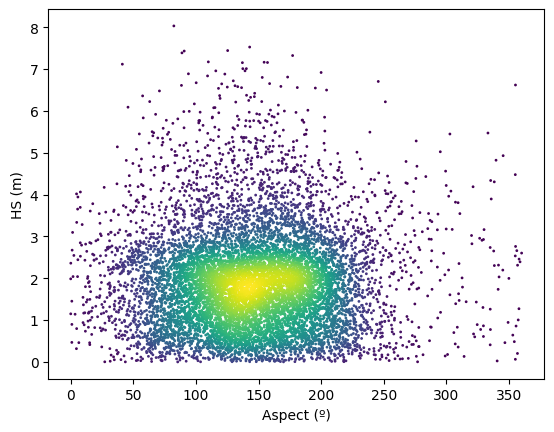

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.0 * x + 1.79
MSE: 1.326255
R^2: 0.0004884600639343262


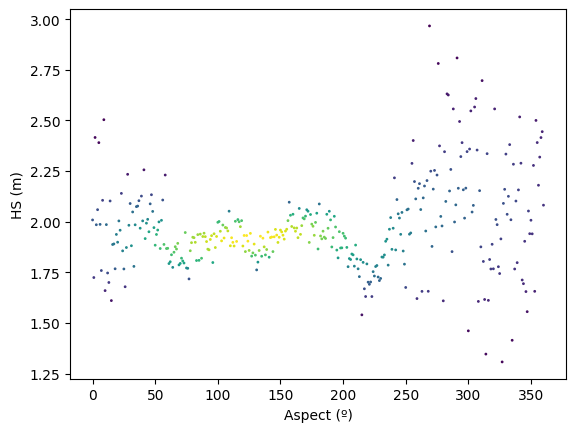

Fitted function: -0.0 * x^3 + 0.0 * x^2 + -0.0 * x + 2.03
MSE: 0.04624347030292788
R^2: 0.08369160007552545
____________________________________________________________________________________________________ 
 snowmap_2014_ads_100_extent_maskiert_nosnow0_noausreisser


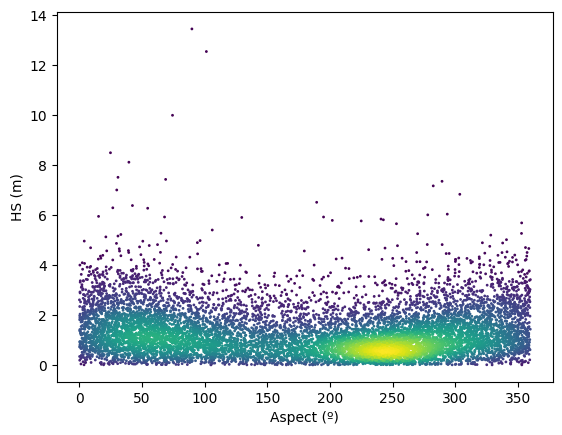

Fitted function: 0.0 * x^3 + -0.0 * x^2 + -0.0 * x + 1.74
MSE: 0.8414539
R^2: 0.07096606492996216


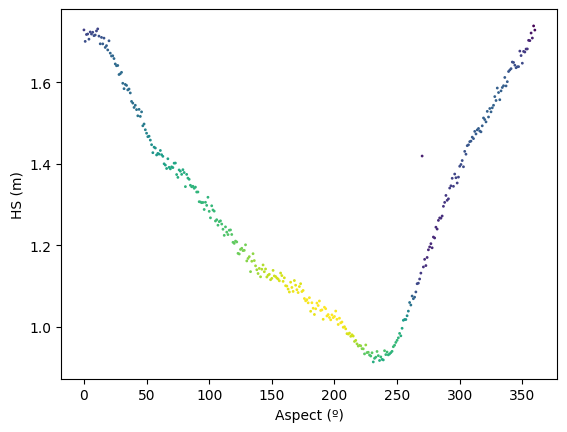

Fitted function: 0.0 * x^3 + -0.0 * x^2 + -0.0 * x + 1.75
MSE: 0.0029479685855369237
R^2: 0.951086138340326
____________________________________________________________________________________________________ 
 HS_Davos_20200406_2m_epsg2056


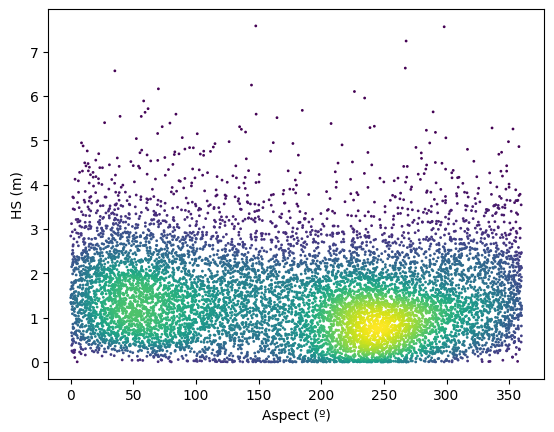

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.0 * x + 1.66
MSE: 0.89512014
R^2: 0.039072513580322266


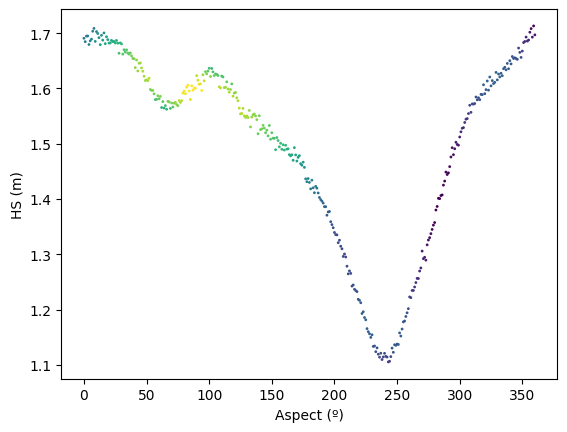

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.0 * x + 1.62
MSE: 0.005647454405481608
R^2: 0.807883629399974
____________________________________________________________________________________________________ 
 HS_Davos_20211604_2m_epsg2056


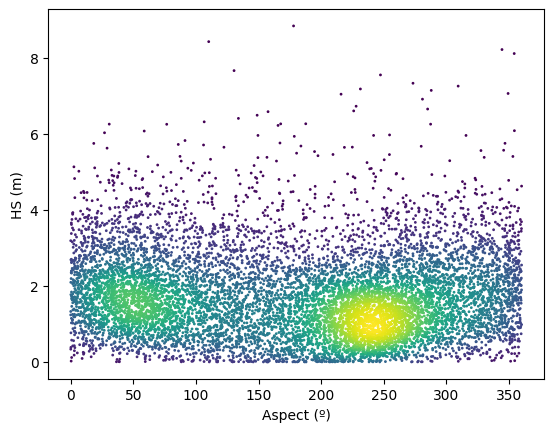

Fitted function: 0.0 * x^3 + -0.0 * x^2 + -0.0 * x + 2.0
MSE: 1.099697
R^2: 0.03772169351577759


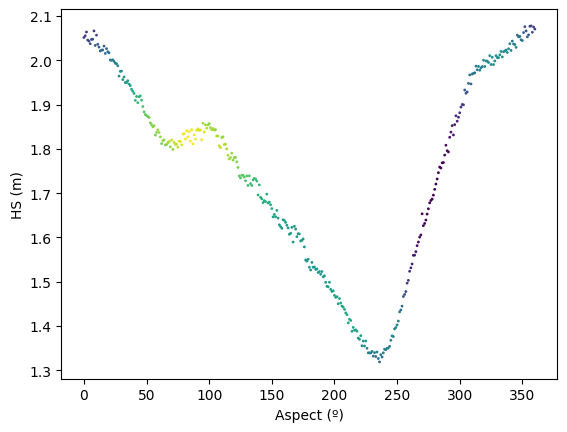

Fitted function: 0.0 * x^3 + -0.0 * x^2 + -0.0 * x + 2.03
MSE: 0.0076862449096074025
R^2: 0.8416847327459004
____________________________________________________________________________________________________ 
 snowmap_2013_ads_80_extent_maskiert_nosnow0_noausreisser


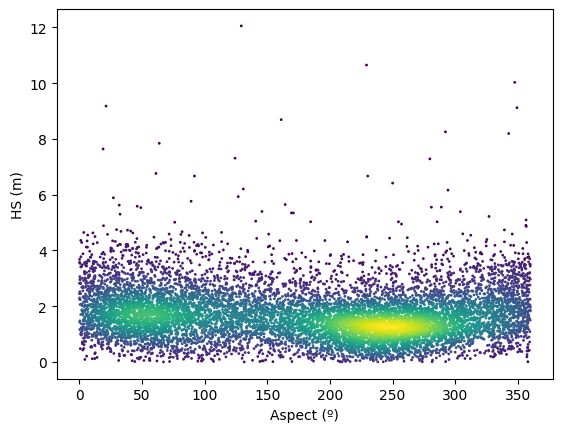

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.0 * x + 1.95
MSE: 0.7533867
R^2: 0.06477272510528564


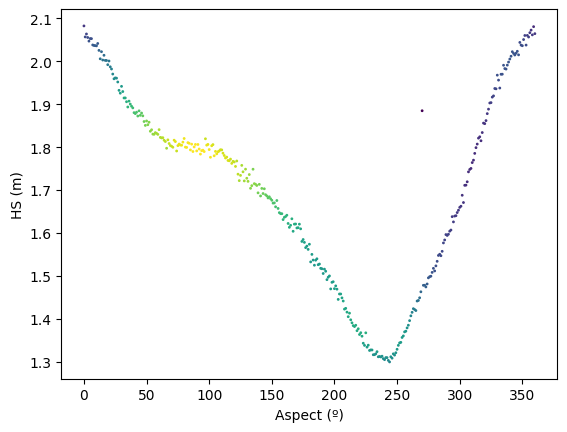

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.0 * x + 1.96
MSE: 0.004678190014346341
R^2: 0.9039499639165859
____________________________________________________________________________________________________ 
 snowmap_2012_ads_80_extent_maskiert_nosnow0_noausreisser


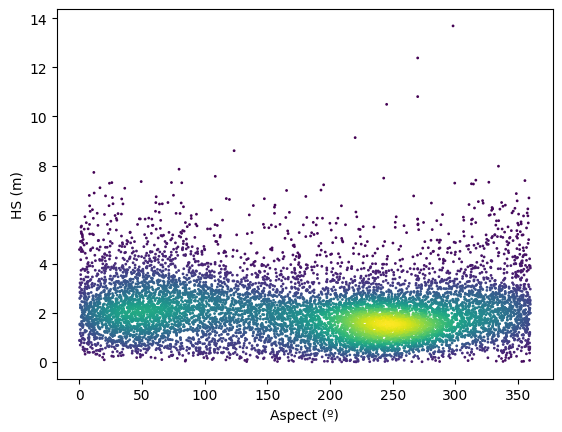

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.0 * x + 2.29
MSE: 1.30479
R^2: 0.051205456256866455


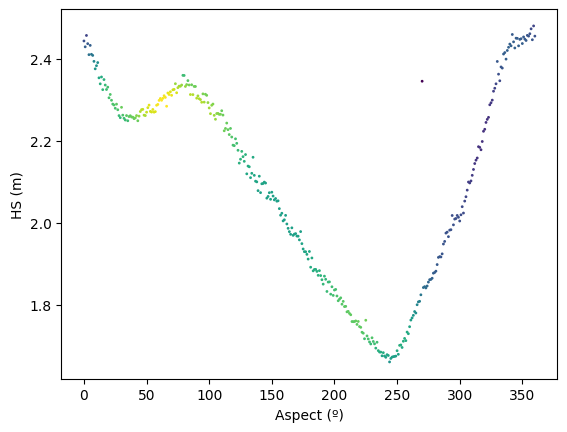

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.0 * x + 2.28
MSE: 0.005044787651697701
R^2: 0.9133690961617349
____________________________________________________________________________________________________ 
 snowmap_2015_ads_100_extent_maskiert_nosnow0_noausreisser


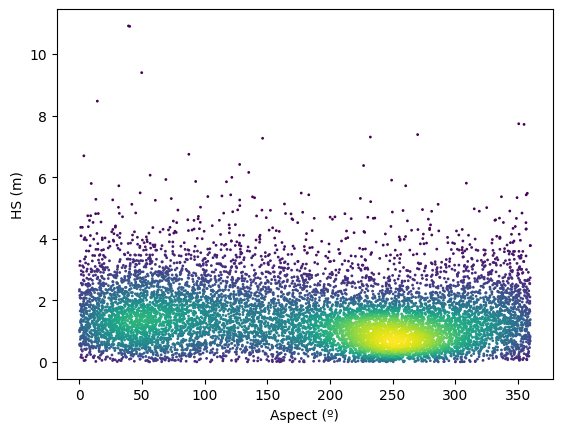

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.01 * x + 1.49
MSE: 0.910857
R^2: 0.04610574245452881


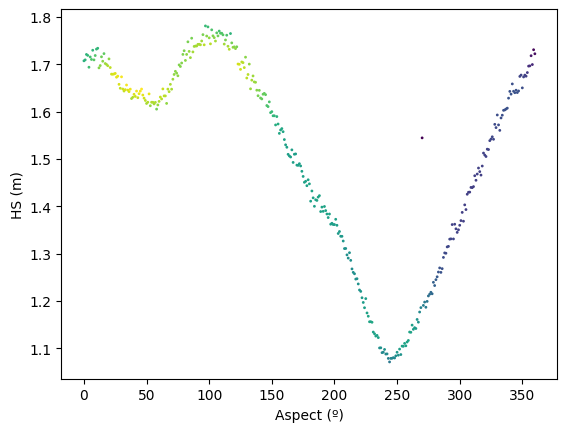

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.01 * x + 1.54
MSE: 0.006192692724876292
R^2: 0.8617516485480097
____________________________________________________________________________________________________ 
 snowmap_20160126_ads_100_extent_maskiert_nosnow0_noausreisser


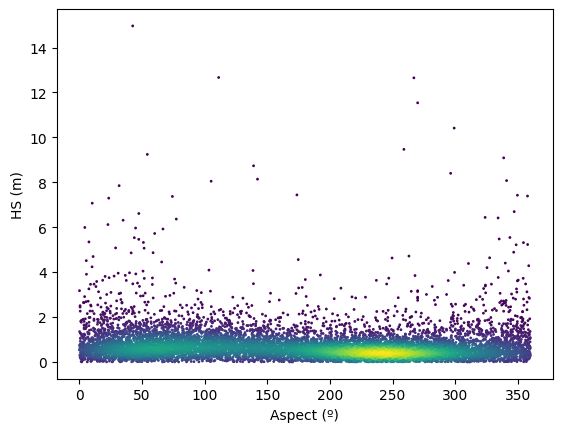

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.0 * x + 0.85
MSE: 0.502517
R^2: 0.03921550512313843


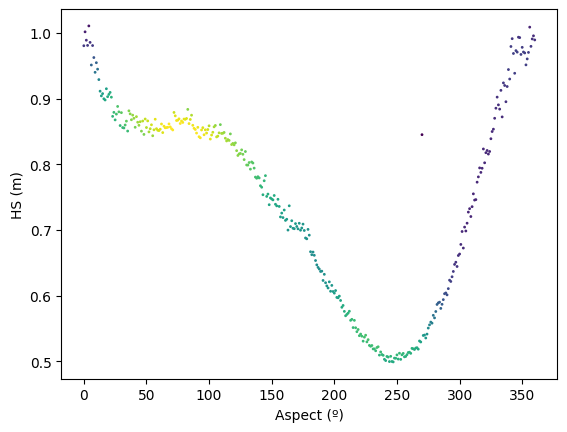

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.0 * x + 0.86
MSE: 0.0019356775155868866
R^2: 0.9124302156027152
____________________________________________________________________________________________________ 
 HS_c_20220223_1m_epsg2056


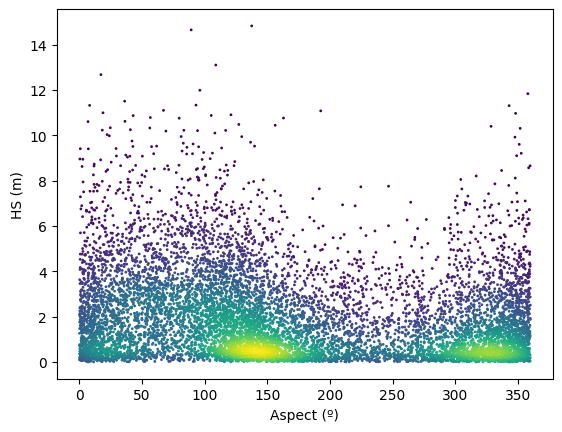

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.01 * x + 2.21
MSE: 3.2221441
R^2: 0.06891751289367676


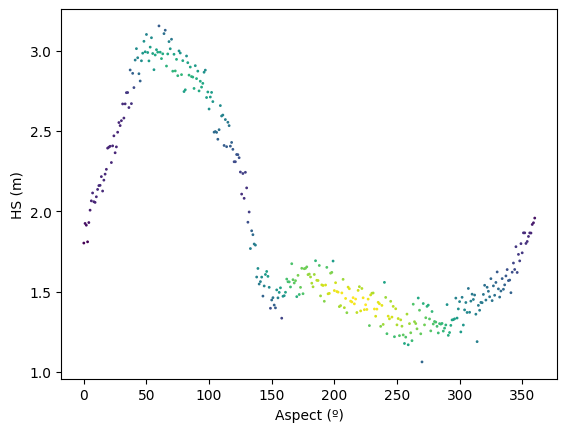

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.01 * x + 2.3
MSE: 0.06009167408250526
R^2: 0.8331309000378316
____________________________________________________________________________________________________ 
 HS_Davos_20170316_2m_epsg2056


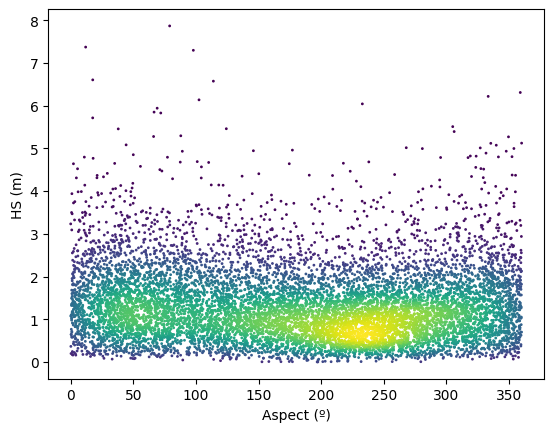

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.0 * x + 1.52
MSE: 0.66768837
R^2: 0.029099762439727783


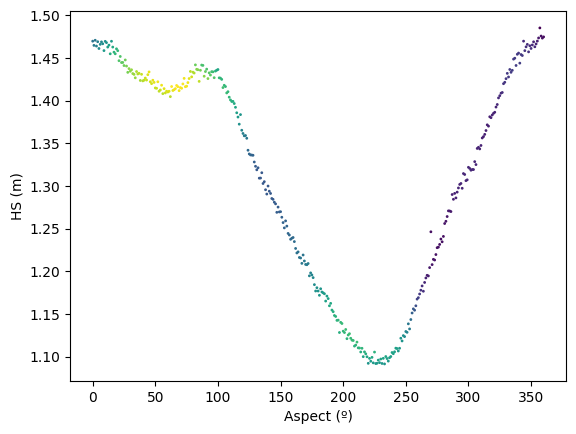

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.0 * x + 1.45
MSE: 0.0016162484465848303
R^2: 0.9005285845619113
____________________________________________________________________________________________________ 
 HS_Davos_20180411_2m_epsg2056


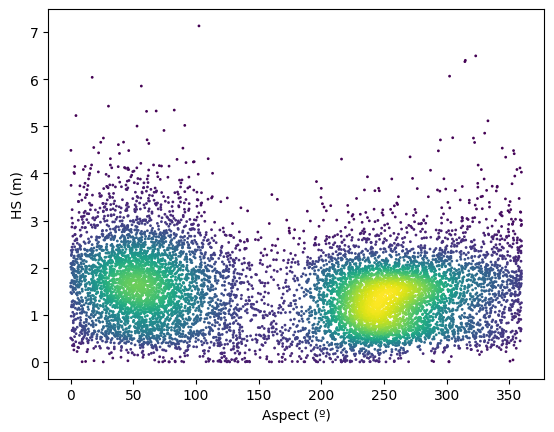

Fitted function: 0.0 * x^3 + -0.0 * x^2 + -0.0 * x + 1.86
MSE: 0.5909336
R^2: 0.06169867515563965


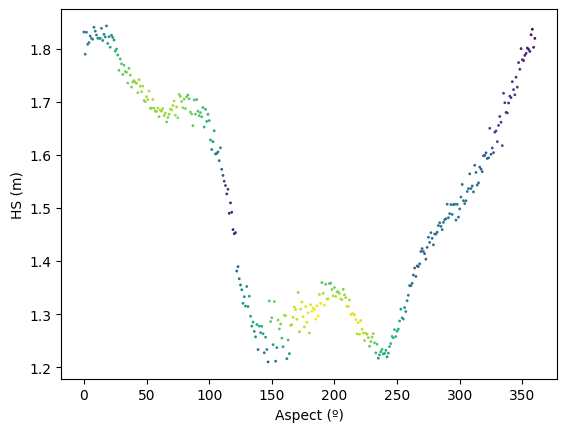

Fitted function: 0.0 * x^3 + -0.0 * x^2 + -0.0 * x + 1.89
MSE: 0.004041659036005532
R^2: 0.9003069133985563
____________________________________________________________________________________________________ 
 snowmap_20160420_ads_100_extent_maskiert_nosnow0_noausreisser


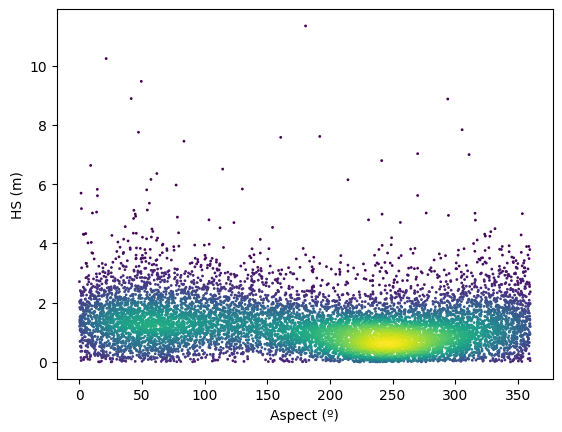

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.01 * x + 1.41
MSE: 0.66552484
R^2: 0.0714111328125


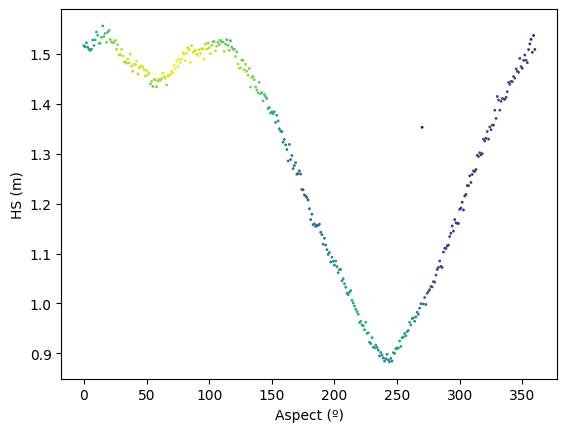

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.01 * x + 1.4
MSE: 0.00519178374146291
R^2: 0.8883325376569581
____________________________________________________________________________________________________ 
 HS_Laucherenalp_20220224_2m_epsg2056


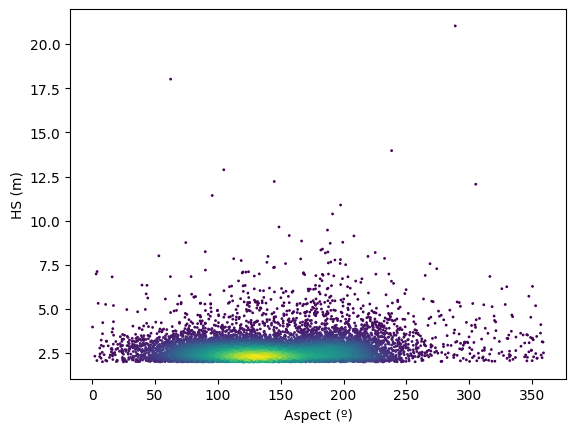

Fitted function: -0.0 * x^3 + 0.0 * x^2 + -0.01 * x + 3.23
MSE: 0.6795231
R^2: 0.02589017152786255


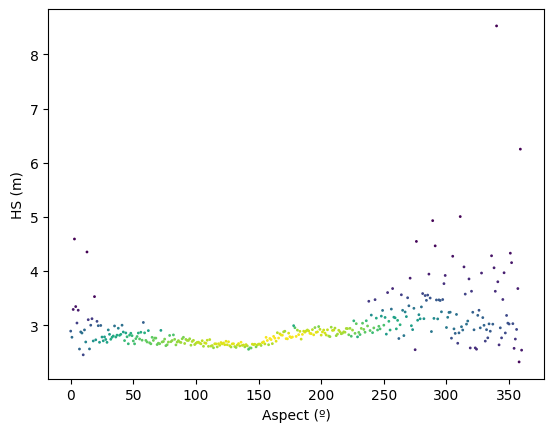

Fitted function: -0.0 * x^3 + 0.0 * x^2 + -0.01 * x + 3.17
MSE: 0.1993829787833897
R^2: 0.2686147548453517
____________________________________________________________________________________________________ 
 snowmap_2010_ads_80_extent_maskiert_nosnow0_noausreisser


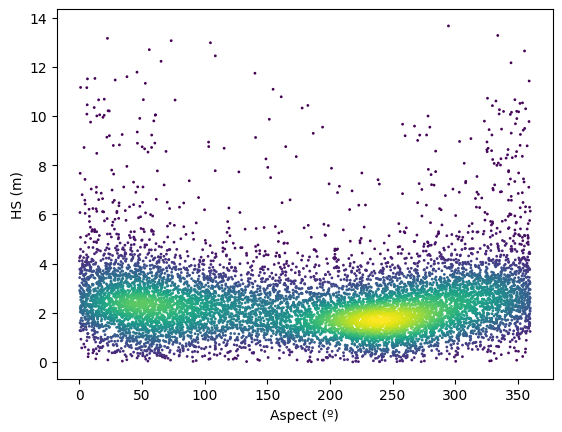

Fitted function: 0.0 * x^3 + -0.0 * x^2 + -0.0 * x + 2.92
MSE: 1.8675393
R^2: 0.0813668966293335


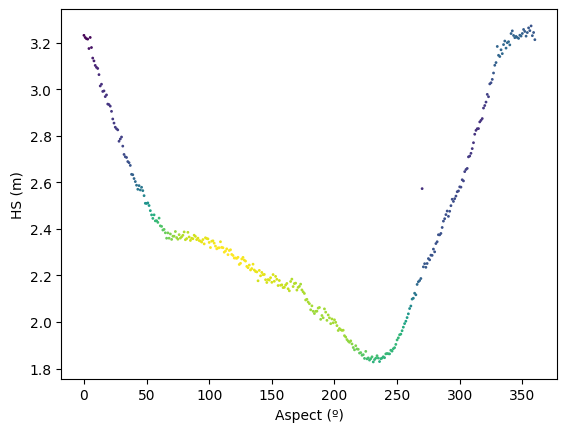

Fitted function: 0.0 * x^3 + -0.0 * x^2 + -0.01 * x + 3.03
MSE: 0.013783042180045236
R^2: 0.9199062250052393


In [18]:
for index, series in df.iterrows(): 
    print("_"*100, "\n", series.name)
    mapping = get_mapping(series)
    plot_map(mapping)
    new_mapping = plot_slices(mapping)